## Code for Car Detection Using Singal short detection

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
net=cv2.dnn.readNetFromCaffe('model/MobileNetSSD_deploy.prototxt', 'model/MobileNetSSD_deploy.caffemodel')

def predict_Car(img_path): 
  # To Predict the person in the image
  img=cv2.imread(img_path)
  (h, w) = img.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)),0.007843, (300, 300), 127.5)
  net.setInput(blob)
  detections = net.forward()
  for i in np.arange(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence >0.60:
      idx = int(detections[0, 0, i, 1])
      if idx==7:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        cv2.rectangle(img, (startX, startY), (endX, endY),(0,0,255), 1)
        roi=img[startY:endY,startX:endX]
        label = "{} {:.2f} %".format("Car",round(confidence * 100))
        return label,roi,img


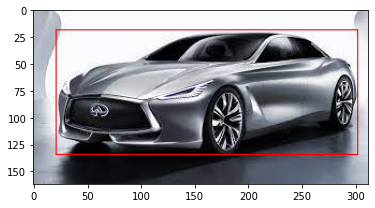

In [2]:
label,roi,img=predict_Car('images/1222.jpeg')# Put The input iamge over here
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

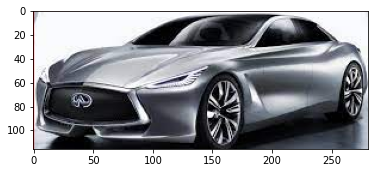

In [3]:
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
import time

import cv2
import numpy as np


class YOLO:

    def __init__(self, config, model, labels, size=256, confidence=0.10, threshold=0.10):
        self.confidence = confidence
        self.threshold = threshold
        self.size = size

        self.labels = labels
        try:
            self.net = cv2.dnn.readNetFromDarknet(config, model)
        except:
            raise ValueError("Couldn't find the models!\nDid you forget to download them manually (and keep in the correct directory, models/) or run the shell script?")

    def inference_from_file(self, file):
        mat = cv2.imread(file)
        return self.inference(mat)

    def inference(self, image):
        ih, iw = image.shape[:2]

        ln = self.net.getLayerNames()
        ln = [ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]

        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (self.size, self.size), swapRB=True, crop=False)
        self.net.setInput(blob)
        start = time.time()
        layerOutputs = self.net.forward(ln)
        end = time.time()
        inference_time = end - start

        boxes = []
        confidences = []
        classIDs = []

        for output in layerOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                # filter out weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > self.confidence:
                    # scale the bounding box coordinates back relative to the
                    # size of the image, keeping in mind that YOLO actually
                    # returns the center (x, y)-coordinates of the bounding
                    # box followed by the boxes' width and height
                    box = detection[0:4] * np.array([iw, ih, iw, ih])
                    (centerX, centerY, width, height) = box.astype("int")
                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, self.confidence, self.threshold)

        results = []
        if len(idxs) > 0:
            for i in idxs.flatten():
                # extract the bounding box coordinates
                x, y = (boxes[i][0], boxes[i][1])
                w, h = (boxes[i][2], boxes[i][3])
                id = classIDs[i]
                confidence = confidences[i]

                results.append((id, self.labels[id], confidence, x, y, w, h))

        return iw, ih, inference_time, results


## LP Model

In [5]:
import cv2
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

yolo = YOLO("model/obj.cfg", "model/obj_60000.weights", ['car','truck','bus','motorcycle','auto','carLP','truckLP','busLP','motorcycleLP','autoLP'])

img_= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
roi_= cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
width, height, inference_time, results = yolo.inference(img)

conf_sum =0
detection_count=0

ls=img

for detection in results:
        id, name, confidence, x, y, w, h = detection
        if id>=5 and id<10:
            cx = x + (w / 2)
            cy = y + (h / 2)
            conf_sum += confidence
            detection_count += 1
            color = (0, 0, 255)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            ls= img[y:y+h,x:x+w]
            
    
            try:
                plt.imshow(cv2.cvtColor(ls, cv2.COLOR_BGR2RGB))
                
    
            except:
                pass

## Code for OCR

In [6]:
import easyocr

reader = easyocr.Reader(['en'])
result = reader.readtext(ls)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]

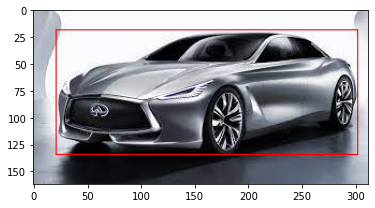

''

In [7]:
text=''
try:
    
    text = result[0][-2]+' '+result[1][-2]+' '+result[2][-2]+' '+result[3][-2]
except IndexError:
    try:
        text = result[0][-2]+' '+result[1][-2]
    except:
        try:
            text = result[0][-2]+' '+result[1][-2]+' '+result[2][-2]
        except:
            try:
                text=result[0][-2]
            except:pass
except Exception as e:
    print(e)
    
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img_, text=text, org=(100,150), fontFace=font, fontScale=1, color=(0,222,200), thickness=5, lineType=cv2.LINE_AA)
#res = cv2.rectangle(img_, (x, y), (x + w, y + h), color, 1)
plt.imshow(img_)
plt.show()
text

## Code for color detction

In [8]:
import cv2
import tensorflow as tf
import numpy as np
model = tf.lite.Interpreter(model_path="model/color2.tflite")
model.allocate_tensors()
input_details = model.get_input_details()
output_details = model.get_output_details()
label = np.array(['black','blue','green','pink','red','white','yellow'])
input_img = tf.reshape(tf.image.resize(img_, [224,224]), [1,224,224,3])
floating_model = input_details[0]['dtype'] == np.float32
if floating_model:input_img = (np.float32(input_img) - 127.5) / 127.5
model.set_tensor(input_details[0]['index'], input_img)
model.invoke()  
predictions =  model.get_tensor(output_details[0]['index'])
color_class=''


if max(predictions[0])>0.75:
    color_class=label[np.argmax(predictions)]+' '+str(round(max(predictions[0])*100,1))+' '+'%'
else:
    color_class='Not Sure'

color_class


'Not Sure'

## Car brand

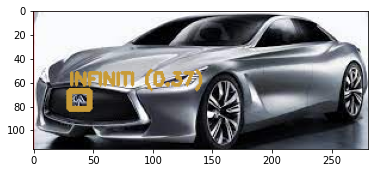

'INFINITI (0.37)'

In [9]:
import cv2
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

yolo = YOLO("model/yolov4-tiny-custom.cfg", "model/yolov4-tiny-custom_final.weights", ['Audi','BENTLEY','BMW','CHEVROLET','CHRYSLER','CITROEN',
'FERRARI','FORD','HONDA','HYUNDAI','INFINITI','ISUZU','JAGUAR','JEEP','Renault','MITSUBISHI','NISSAN','LEXUS',
'MERCEDES-BENZ','VOLVO','SUZUKI'])
width, height, inference_time, results = yolo.inference(roi_)

conf_sum =0
detection_count=0

ls=img
text_=''
for detection in results:
        id, name, confidence, x, y, w, h = detection
        cx = x + (w / 2)
        cy = y + (h / 2)
        conf_sum += confidence
        detection_count += 1
        color = (200, 155, 55)
        cv2.rectangle(roi_, (x, y), (x + w, y + h), color, 4)
        text_ = "%s (%s)" % (name, round(confidence, 2))
        
        cv2.putText(roi_,text_, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
plt.imshow(roi_)
plt.show()
text_
           

In [10]:

import cv2
import numpy as np
import time
import cv2
import easyocr
from google.colab.patches import cv2_imshow
import tensorflow as tf
import pandas as pd


car_net=cv2.dnn.readNetFromCaffe('model/MobileNetSSD_deploy.prototxt', 'model/MobileNetSSD_deploy.caffemodel')
def predict_Car(img): # To predict the car and their confidence
    
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)),0.007843, (300, 300), 127.5)
    car_net.setInput(blob)
    detections = car_net.forward()
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence >0.60:
            idx = int(detections[0, 0, i, 1])
            if idx==7:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                cv2.rectangle(img, (startX, startY), (endX, endY),(0,0,255), 1)
                roi=img[startY:endY,startX:endX]
        
                label = "{} {:.2f} %".format("Car",round(confidence * 100))
                return label,roi

            
            
            

            
yolo = YOLO("model/obj.cfg", "model/obj_60000.weights", ['car','truck','bus','motorcycle','auto','carLP','truckLP','busLP','motorcycleLP','autoLP'])            
            
def predictNPD(roi): #To predict the number plate of the car along with text data
    roi_=img= cv2.cvtColor(roi,cv2.COLOR_RGB2BGR)
    width, height, inference_time, results = yolo.inference(roi_)
    conf_sum,detection_count,ls,text=0,0,roi,''
    for detection in results:
        id, name, confidence, x, y, w, h = detection
        if id>=5 and id<10:
            cx = x + (w / 2)
            cy = y + (h / 2)
            conf_sum += confidence
            detection_count += 1
            color = (0, 0, 255)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            ls= img[y:y+h,x:x+w]
            reader = easyocr.Reader(['en'])
            result = reader.readtext(ls)
            try:
                text = result[0][-2]+' '+result[1][-2]
            except IndexError:
                try:
                    text = result[0][-2]
                except:pass
            except Exception as e:print(e)
            return text

def colorDetection(roi): # to predict the color of the car 
    
    roi_=img= cv2.cvtColor(roi,cv2.COLOR_RGB2BGR)
    model = tf.lite.Interpreter(model_path="model/color2.tflite")
    model.allocate_tensors()
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    label = np.array(['black','blue','green','pink','red','white','yellow'])
    input_img = tf.reshape(tf.image.resize(roi_, [224,224]), [1,224,224,3])
    floating_model = input_details[0]['dtype'] == np.float32
    if floating_model:input_img = (np.float32(input_img) - 127.5) / 127.5
    model.set_tensor(input_details[0]['index'], input_img)
    model.invoke()  
    predictions =  model.get_tensor(output_details[0]['index'])
    if max(predictions[0])>0.75:
        color_class=label[np.argmax(predictions)]+' '+str(round(max(predictions[0])*100,1))+' '+'%'
    else:
        color_class='Not Sure'
    return color_class
    
   
        
    
    
    
    color_class=label[np.argmax(predictions)]

    return color_class

def brandDetection(roi): #to pridect the brand of car
    yolo = YOLO("model/yolov4-tiny-custom.cfg", "model/yolov4-tiny-custom_final.weights", ['Audi','BENTLEY','BMW','CHEVROLET','CHRYSLER','CITROEN',
    'FERRARI','FORD','HONDA','HYUNDAI','INFINITI','ISUZU','JAGUAR','JEEP','Renault','MITSUBISHI','NISSAN','LEXUS',
    'MERCEDES-BENZ','VOLVO','SUZUKI'])
    roi_=img= cv2.cvtColor(roi,cv2.COLOR_RGB2BGR)
    width, height, inference_time, results = yolo.inference(roi_)
    conf_sum,detection_count=0,0
    for detection in results:
        id, name, confidence, x, y, w, h = detection
        cx = x + (w / 2)
        cy = y + (h / 2)
        conf_sum += confidence
        detection_count += 1
        text = "%s (%s)" % (name, round(confidence, 2))
        return text
    


    
    
    
    
    
    


    
    

    
    

    
    






cap = cv2.VideoCapture('https://media.gettyimages.com/videos/lexus-revolving-on-turntable-front-end-headlight-steering-wheel-and-video-id680318864') # Insert video path or live ip address here

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('output/filename.mp4', cv2.VideoWriter_fourcc(*'MJPG'),24, size)
print('*'*20,'Start Processing Video','*'*20)
car,NPT,CC,BC=[],[],[],[]
while True:
    
    
    ret,frame=cap.read()
    if frame is None:
        break
    label,roi,color_class,brand_class='',None,'',''
    try:
        label,roi=predict_Car(frame)
        car.append(label)
    
        text=predictNPD(roi)
        NPT.append(text)
    
        color_class=colorDetection(roi)
        CC.append(color_class)
    
        brand_class=brandDetection(roi)
        BC.append(brand_class)
    except Exception as e:pass
    
    cv2.putText(frame, label, (50,150), cv2.FONT_HERSHEY_SIMPLEX,1.0, (0,255,255), 2)
    cv2.putText(frame, text, (50,200), cv2.FONT_HERSHEY_SIMPLEX,1.0, (0,255,255), 2)
    cv2.putText(frame, color_class, (50,250), cv2.FONT_HERSHEY_SIMPLEX,1.0, (0,255,255), 2)
    cv2.putText(frame, brand_class, (50,300), cv2.FONT_HERSHEY_SIMPLEX,1.0, (0,255,255), 2)
    
    
    

    



    cv2_imshow(frame)
    result.write(frame)
    
    


    if cv2.waitKey(1)==13:
        break
cap.release()
cv2.destroyAllWindows()
print('*'*20,'End Processing Video','*'*20)
data={'Vechile Type':pd.Series(car),'Number Plate Text':pd.Series(NPT),'Color':pd.Series(CC),'Brand':pd.Series(BC)}
df=pd.DataFrame(data)
df.to_csv('data_store/final.csv')
df


******************** Start Processing Video ********************
******************** End Processing Video ********************


,Vechile Type,Number Plate Text,Color,Brand
0,Car 100.00 %,None,Not Sure,LEXUS (0.66)
1,Car 100.00 %,None,Not Sure,LEXUS (0.55)
2,Car 100.00 %,None,Not Sure,LEXUS (0.41)
3,Car 100.00 %,None,Not Sure,LEXUS (0.65)
4,Car 100.00 %,None,Not Sure,LEXUS (0.71)
...,...,...,...,...
96,Car 100.00 %,None,Not Sure,LEXUS (0.81)
97,Car 100.00 %,None,Not Sure,LEXUS (0.77)
98,Car 100.00 %,None,Not Sure,LEXUS (0.7)
99,Car 100.00 %,None,Not Sure,LEXUS (0.97)
